In [1]:
%%classpath add mvn
com.github.haifengl smile-scala_2.11 1.5.3

## Télécharger le fichier loanf.csv du site https://sites.google.com/site/lebbah/datatp

### How can I predict interest rates based on borrower and loan attributes?

The [Lending Club](https://www.lendingclub.com/) is a peer-to-peer lending site where members make loans to each other. The site makes anonymized data on loans and borrowers publicly available. We're going to use these data to explore how the interest rate charged on loans depends on various factors.

We want to explore these data, try to gain some insights into what might be useful in creating a linear regression model, and to separate out "the noise".

We follow these steps, something we will do in future for other data sets as well.

    Browse the data
    Data cleanup
    Visual exploration
    Model derivation

### I. Browse Data

The data have the following variables (with data type and explanation of meaning)

* Amount.Requested - numeric. The amount (in dollars) requested in the loan application.
* Amount.Funded.By.Investors - numeric. The amount (in dollars) loaned to the individual.
* Interest.rate – character. The lending interest rate charged to the borrower.
* Loan.length - character. The length of time (in months) of the loan.
* Loan.Purpose – categorical variable. The purpose of the loan as stated by the applicant.
* Debt.to.Income.Ratio – character The % of consumer’s gross income going toward paying debts.
* State - character. The abbreviation for the U.S. state of residence of the loan applicant.
* Home.ownership - character. Indicates whether the applicant owns, rents, or has a mortgage.
* Monthly.income -­ categorical. The monthly income of the applicant (in dollars).
* FICO.range – categorical (expressed as a string label e.g. “650-655”). A range indicating the applicants FICO score.
* Open.CREDIT.Lines - numeric. The number of open lines of credit at the time of application.
* Revolving.CREDIT.Balance - numeric. The total amount outstanding all lines of credit.
* Inquiries.in.the.Last.6.Months - numeric. Number of credit inquiries in the previous 6 months.
* Employment.Length - character. Length of time employed at current job.



French

* Amount.Requested - numérique. Le montant (en dollars) demandé dans la demande de prêt.
* Amount.Funded.By.Investors - numérique. Le montant (en dollars) prêté à l'individu.
* Interest.rate  - personnage. Le taux d'intérêt du prêteur payé à l'emprunteur.
* Loan.length - character. La durée (en mois) du prêt.
* Loan.Purpose - variable catégorielle. Le but du prêt tel que stipulé par le demandeur.
* Debt.to.Income.Ratio - personnage Le pourcentage du revenu brut du consommateur versant des dettes.
* State - character. L'abréviation de l'État de résidence américain du demandeur de prêt.
* Home.ownership  - caractère. Indique si le demandeur possède, loue ou possède un prêt hypothécaire.
* Monthly.income  - catégorique. Le revenu mensuel du demandeur (en dollars).
* FICO.range - catégorique (exprimée sous la forme d'une étiquette de chaîne, par exemple "650-655"). Une fourchette indiquant le score FICO des candidats.
* Open.CREDIT.Lines  - numeric. Le nombre de lignes ouvertes de crédit au moment de la demande.
* Revolving.CREDIT.Balance- numeric. Le montant total en souffrance de toutes les lignes de crédit.
* Inquiries.in.the.Last.6.Months - numeric. Nombre de demandes de crédit au cours des 6 derniers mois.
* Employment.Length  - caractère. Durée du temps occupée dans le travail actuel.



We see here that:

    the interest rate information has "%" symbols in it.
    loan length has " months" in it

Other than that we can also see (exploration exercise):

    there are a couple of values that are so large they must be typos
    some values are missing "NA" values i.e. not available.
    the FICO Range is really a numeric entity but is represented as a categorical variable in the data.


To summarize - cleaning our data involves:

    removing % signs from rates
    removing the word ” months" from loan length.
    managing outliers - remove such rows in this case
    managing NA - remove such rows in this case

There is one especially high outlier with monthly income > 100K$+.
This is likely to be a typo and is removed as a data item.
  There is also one data item with all N/A - this is also removed.


In [2]:
import scala.io.Source
import scala.util.Try
import java.io._

import smile._
//import smile.io._
import smile.util._
import smile.math._
import smile.math.distance._
import smile.math.kernel._
import smile.math.matrix._
import smile.stat.distribution._
import smile.data._
import smile.interpolation._
import smile.validation._
import smile.association._
import smile.regression._
import smile.classification._
import smile.feature._
import smile.clustering._
import smile.vq._
import smile.manifold._
import smile.mds._
import smile.sequence._
import smile.projection._
import smile.nlp._
import smile.plot._
import java.awt.Color
import smile.wavelet._
import smile.data.parser._

import scala.io.Source
import scala.util.Try
import java.io._
import smile._
import smile.util._
import smile.math._
import smile.math.distance._
import smile.math.kernel._
import smile.math.matrix._
import smile.stat.distribution._
import smile.data._
import smile.interpolation._
import smile.validation._
import smile.association._
import smile.regression._
import smile.classification._
import smile.feature._
import smile.clustering._
import smile.vq._
import smile.manifold._
import smile.mds._
import smile.sequence._
import smile.projection._
import smile.nlp._
import smile.plot._
import java.awt.Color
import smile.wavelet._
import smile.data.parser._


In [3]:
class SimpleCSVHeader(header:Array[String]) extends Serializable {
  val index = header.zipWithIndex.toMap
  def apply(array:Array[String], key:String):String = array(index(key))
}

defined class SimpleCSVHeader


In [4]:
%%bash
wget https://raw.githubusercontent.com/briandalessandro/DataScienceCourse/master/ipython/data/loansData.csv -O /tmp/loansData.csv

--2019-07-10 11:47:56--  https://raw.githubusercontent.com/briandalessandro/DataScienceCourse/master/ipython/data/loansData.csv
Résolution de raw.githubusercontent.com (raw.githubusercontent.com)… 151.101.120.133
Connexion à raw.githubusercontent.com (raw.githubusercontent.com)|151.101.120.133|:443… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 247404 (242K) [text/plain]
Sauvegarde en : « /tmp/loansData.csv »

     0K .......... .......... .......... .......... .......... 20% 1,21M 0s
    50K .......... .......... .......... .......... .......... 41% 1,93M 0s
   100K .......... .......... .......... .......... .......... 62%  886K 0s
   150K .......... .......... .......... .......... .......... 82% 1,03M 0s
   200K .......... .......... .......... .......... .         100% 1,34M=0,2s

2019-07-10 11:47:57 (1,18 MB/s) — « /tmp/loansData.csv » sauvegardé [247404/247404]




Je n'ai pas les fichiers 

```scala
import scala.io.Source

val path1="/Users/lebbah/Drive/MesDoc/cours/Sylvie/PYTHON/EX10_R_teledetection_spatiale-RegLin/EX10_enonce/humisat.dat"
val csv = Source.fromFile(path1).getLines.map(_.split(" ")).toArray.map(_.slice(3,6))
//(_.replaceAll("\\s", "")```

In [5]:
val path = "/tmp/loansData.csv"
val csv = Source.fromFile(path).getLines.toArray

[CustNUm,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length, 81174,20000,20000,8.90%,36 months,debt_consolidation,14.90%,SC,MORTGAGE,6541.67,735-739,14,14272,2,< 1 year, 99592,19200,19200,12.12%,36 months,debt_consolidation,28.36%,TX,MORTGAGE,4583.33,715-719,12,11140,1,2 years, 80059,35000,35000,21.98%,60 months,debt_consolidation,23.81%,CA,MORTGAGE,11500,690-694,14,21977,1,2 years, 15825,10000,9975,9.99%,36 months,debt_consolidation,14.30%,KS,MORTGAGE,3833.33,695-699,10,9346,0,5 years, 33182,12000,12000,11.71%,36 months,credit_card,18.78%,NJ,RENT,3195,695-699,11,14469,0,9 years, 62403,6000,6000,15.31%,36 months,other,20.05%,CT,OWN,4891.67,670-674,17,10391,2,3 years, 48808,10000,10000,7.90%,36 months,debt_consolidation,26.09%,MA,RENT,2916.67,720-724,10,15957,0,10+ years, 22090,33500,33450,17.14%,6

In [7]:
//val data=csv.getLines.toList.map(line => line.replace("\"", "").split(",").map(elem => elem.trim))
val data = csv.map(_.replaceAll("%",""))
              .map(_.replaceAll("months",""))
              .map(_.replaceAll("NA","0"))
              .map(_.replaceAll("\"",""))
//val dataf=csvf.getLines.toList.map(line => line.replace("\"", ""). //
//                                   split(",").map(elem => elem.trim))


[CustNUm,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length, 81174,20000,20000,8.90,36 ,debt_consolidation,14.90,SC,MORTGAGE,6541.67,735-739,14,14272,2,< 1 year, 99592,19200,19200,12.12,36 ,debt_consolidation,28.36,TX,MORTGAGE,4583.33,715-719,12,11140,1,2 years, 80059,35000,35000,21.98,60 ,debt_consolidation,23.81,CA,MORTGAGE,11500,690-694,14,21977,1,2 years, 15825,10000,9975,9.99,36 ,debt_consolidation,14.30,KS,MORTGAGE,3833.33,695-699,10,9346,0,5 years, 33182,12000,12000,11.71,36 ,credit_card,18.78,NJ,RENT,3195,695-699,11,14469,0,9 years, 62403,6000,6000,15.31,36 ,other,20.05,CT,OWN,4891.67,670-674,17,10391,2,3 years, 48808,10000,10000,7.90,36 ,debt_consolidation,26.09,MA,RENT,2916.67,720-724,10,15957,0,10+ years, 22090,33500,33450,17.14,60 ,credit_card,14.70,LA,MORTGAGE,13863.42,705-709,12,2787

In [8]:
val header = new SimpleCSVHeader(data.head.split(","))

val rowsf = data.map(line => header(line.split(","),"Loan.Length") ) 

//val AmountRequested = rowsf.map(row => header(row,"Amount.Requested"))


[Loan.Length, 36 , 36 , 60 , 36 , 36 , 36 , 36 , 60 , 36 , 36 , 36 , 36 , 60 , 36 , 36 , 60 , 36 , 60 , 36 , 60 , 36 , 60 , 60 , 36 , 60 , 36 , 36 , 36 , 36 , 36 , 60 , 36 , 60 , 60 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 60 , 60 , 36 , 60 , 36 , 60 , 60 , 60 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 60 , 36 , 60 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 60 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 60 , 36 , 36 , 60 , 36 , 60 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 60 , 36 , 60 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 60 , 60 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 60 , 60 , 36 , 36 , 36 , 36 , 36 , 60 , 60 , 60 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 36 , 60 , 36 , 36 , 60 , 60 , 60 , 36 , 36 , 36 , 36 , 60 , 3

In [9]:
val parser = new DelimitedTextParser()
parser.setDelimiter(",")
parser.setColumnNames(true)
parser.setMissingValuePlaceholder("NA")

val attributes = new Array[Attribute](15)
attributes(0) = new NumericAttribute("V0")
attributes(1) = new NumericAttribute("V1")
attributes(2) = new NumericAttribute("V2")
attributes(3) = new NominalAttribute("V3")
attributes(4) = new NominalAttribute("V4")
attributes(5) = new NominalAttribute("V5")
attributes(6) = new NominalAttribute("V6")
attributes(7) = new NominalAttribute("V7")
attributes(8) = new NominalAttribute("V8")
attributes(9) = new NumericAttribute("V9")
attributes(10) = new NominalAttribute("V10")
attributes(11) = new NumericAttribute("V11")
attributes(12) = new NumericAttribute("V12")
attributes(13) = new NumericAttribute("V13")
attributes(14) = new NominalAttribute("V14")

val members = DataFrame(parser.parse("LoansData", attributes, path))

DataFrame(LoansData
		CustNUm	Amount.Requested	Amount.Funded.By.Investors	Interest.Rate	Loan.Length	Loan.Purpose	Debt.To.Income.Ratio	State	Home.Ownership	Monthly.Income	FICO.Range	Open.CREDIT.Lines	Revolving.CREDIT.Balance	Inquiries.in.the.Last.6.Months	Employment.Length
[1]		81174,0000	20000,0000	20000,0000	8.90%	36 months	debt_consolidation	14.90%	SC	MORTGAGE	6541,6700	735-739	14,0000	14272,0000	2,0000	< 1 year
[2]		99592,0000	19200,0000	19200,0000	12.12%	36 months	debt_consolidation	28.36%	TX	MORTGAGE	4583,3300	715-719	12,0000	11140,0000	1,0000	2 years
[3]		80059,0000	35000,0000	35000,0000	21.98%	60 months	debt_consolidation	23.81%	CA	MORTGAGE	11500,0000	690-694	14,0000	21977,0000	1,0000	2 years
[4]		15825,0000	10000,0000	9975,0000	9.99%	36 months	debt_consolidation	14.30%	KS	MORTGAGE	3833,3300	695-699	10,0000	9346,0000	0,0000	5 years
[5]		33182,0000	12000,0000	12000,0000	11.71%	36 months	credit_card	18.78%	NJ	RENT	3195,0000	695-699	11,0000	14469,0000	0,0000	9 years
[6]		62403,0000

In [10]:
members.attributes

[NUMERIC[CustNUm], NUMERIC[Amount.Requested], NUMERIC[Amount.Funded.By.Investors], NOMINAL[Interest.Rate], NOMINAL[Loan.Length], NOMINAL[Loan.Purpose], NOMINAL[Debt.To.Income.Ratio], NOMINAL[State], NOMINAL[Home.Ownership], NUMERIC[Monthly.Income], NOMINAL[FICO.Range], NUMERIC[Open.CREDIT.Lines], NUMERIC[Revolving.CREDIT.Balance], NUMERIC[Inquiries.in.the.Last.6.Months], NOMINAL[Employment.Length]]

In [11]:
members.attributes(4)

NOMINAL[Loan.Length]

### Rename columns to avoid errors with "withColumn" which doesn't like '.'

```scala
val renamedMembers = members.withColumnRenamed("Amount.Requested", "AmountRequested")
                            .withColumnRenamed("Loan.Length", "LoanLength")
                            .withColumnRenamed("Interest.Rate", "InterestRate")
                            .withColumnRenamed("Debt.To.Income.Ratio", "DebtToIncomeRatio")
                            .withColumnRenamed("Monthly.Income", "MonthlyIncome")
                            .withColumnRenamed("FICO.range", "FICOrange")
                            .withColumnRenamed("Amount.Funded.By.Investors", "AmountFunded")
                            .withColumnRenamed("Loan.Purpose", "LoanPurpose")
                            .withColumnRenamed("Home.Ownership", "HomeOwnership")
                            .withColumnRenamed("Open.CREDIT.Lines","OpenCREDITLines")
                            .withColumnRenamed("Revolving.CREDIT.Balance", "RevolvingCREDITBalance")
                            .withColumnRenamed("Inquiries.in.the.Last.6.Months","InquiriesintheLast6Months")
                            .withColumnRenamed("Employment.Length","EmploymentLength")

```


In [12]:
members(0)

	CustNUm	Amount.Requested	Amount.Funded.By.Investors	Interest.Rate	Loan.Length	Loan.Purpose	Debt.To.Income.Ratio	State	Home.Ownership	Monthly.Income	FICO.Range	Open.CREDIT.Lines	Revolving.CREDIT.Balance	Inquiries.in.the.Last.6.Months	Employment.Length
	81174,0000	20000,0000	20000,0000	8.90%	36 months	debt_consolidation	14.90%	SC	MORTGAGE	6541,6700	735-739	14,0000	14272,0000	2,0000	< 1 year

In [13]:
members(0,3)

DataFrame(LoansData[0, 3]
		CustNUm	Amount.Requested	Amount.Funded.By.Investors	Interest.Rate	Loan.Length	Loan.Purpose	Debt.To.Income.Ratio	State	Home.Ownership	Monthly.Income	FICO.Range	Open.CREDIT.Lines	Revolving.CREDIT.Balance	Inquiries.in.the.Last.6.Months	Employment.Length
[1]		81174,0000	20000,0000	20000,0000	8.90%	36 months	debt_consolidation	14.90%	SC	MORTGAGE	6541,6700	735-739	14,0000	14272,0000	2,0000	< 1 year
[2]		99592,0000	19200,0000	19200,0000	12.12%	36 months	debt_consolidation	28.36%	TX	MORTGAGE	4583,3300	715-719	12,0000	11140,0000	1,0000	2 years
[3]		80059,0000	35000,0000	35000,0000	21.98%	60 months	debt_consolidation	23.81%	CA	MORTGAGE	11500,0000	690-694	14,0000	21977,0000	1,0000	2 years)

In [14]:
members("FICO.Range")

	FICO.Range
[1]	735-739
[2]	715-719
[3]	690-694
[4]	695-699
[5]	695-699
[6]	670-674
[7]	720-724
[8]	705-709
[9]	685-689
[10]	715-719
2490 more values...

In [15]:
members("Loan.Length").head(5)

	Loan.Length
[1]	36 months
[2]	36 months
[3]	60 months
[4]	36 months
[5]	36 months

In [16]:
members("FICO.Range").head(5)

	FICO.Range
[1]	735-739
[2]	715-719
[3]	690-694
[4]	695-699
[5]	695-699

In [17]:
def removePerc : String => String = _.replaceAll("%","")
def removeMonth : String => String = _.replaceAll(" months","")

<function1>

In [18]:
implicit class AttributeVectorString(v: smile.data.AttributeVector) {
    def string(i: Int): String = v.attribute.toString({val vect = v.vector(); vect(i)})
    def string(): Array[String] = (0 until v.size).map(i => string(i)).toArray
}

defined class AttributeVectorString


In [19]:
members("FICO.Range").string

[735-739, 715-719, 690-694, 695-699, 695-699, 670-674, 720-724, 705-709, 685-689, 715-719, 670-674, 665-669, 670-674, 735-739, 725-729, 730-734, 695-699, 740-744, 730-734, 760-764, 665-669, 695-699, 665-669, 695-699, 670-674, 705-709, 675-679, 675-679, 765-769, 760-764, 685-689, 685-689, 720-724, 685-689, 675-679, 780-784, 720-724, 830-834, 715-719, 660-664, 670-674, 720-724, 660-664, 660-664, 675-679, 715-719, 710-714, 670-674, 785-789, 705-709, 750-754, 660-664, 700-704, 665-669, 680-684, 725-729, 670-674, 715-719, 690-694, 755-759, 705-709, 715-719, 680-684, 665-669, 730-734, 725-729, 685-689, 685-689, 705-709, 695-699, 695-699, 715-719, 735-739, 665-669, 670-674, 670-674, 790-794, 700-704, 665-669, 725-729, 710-714, 760-764, 680-684, 690-694, 695-699, 725-729, 810-814, 675-679, 750-754, 685-689, 665-669, 765-769, 670-674, 675-679, 675-679, 750-754, 765-769, 735-739, 665-669, 670-674, 700-704, 705-709, 740-744, 690-694, 720-724, 765-769, 715-719, 710-714, 690-694, 710-714, 775-779, 

In [20]:
val labels = members.colnames

val indexOfIR = labels.indexOf("Interest.Rate")
val indexOfDTIR = labels.indexOf("Debt.To.Income.Ratio")
val indexOfLL = labels.indexOf("Loan.Length")

members.attributes(indexOfIR) = new NominalAttribute("Interest.Rate", members.attributes(indexOfIR).asInstanceOf[NominalAttribute].values.map(removePerc))
members.attributes(indexOfDTIR) = new NominalAttribute("Debt.To.Income.Ratio", members.attributes(indexOfDTIR).asInstanceOf[NominalAttribute].values.map(removePerc))
members.attributes(indexOfLL) = new NominalAttribute("Loan.Length", members.attributes(indexOfLL).asInstanceOf[NominalAttribute].values.map(removeMonth))
members

DataFrame(LoansData
		CustNUm	Amount.Requested	Amount.Funded.By.Investors	Interest.Rate	Loan.Length	Loan.Purpose	Debt.To.Income.Ratio	State	Home.Ownership	Monthly.Income	FICO.Range	Open.CREDIT.Lines	Revolving.CREDIT.Balance	Inquiries.in.the.Last.6.Months	Employment.Length
[1]		81174,0000	20000,0000	20000,0000	8.90	36	debt_consolidation	14.90	SC	MORTGAGE	6541,6700	735-739	14,0000	14272,0000	2,0000	< 1 year
[2]		99592,0000	19200,0000	19200,0000	12.12	36	debt_consolidation	28.36	TX	MORTGAGE	4583,3300	715-719	12,0000	11140,0000	1,0000	2 years
[3]		80059,0000	35000,0000	35000,0000	21.98	60	debt_consolidation	23.81	CA	MORTGAGE	11500,0000	690-694	14,0000	21977,0000	1,0000	2 years
[4]		15825,0000	10000,0000	9975,0000	9.99	36	debt_consolidation	14.30	KS	MORTGAGE	3833,3300	695-699	10,0000	9346,0000	0,0000	5 years
[5]		33182,0000	12000,0000	12000,0000	11.71	36	credit_card	18.78	NJ	RENT	3195,0000	695-699	11,0000	14469,0000	0,0000	9 years
[6]		62403,0000	6000,0000	6000,0000	15.31	36	other	20.05	CT	

In [21]:
val nums = "[0-9]".r

[0-9]

In [24]:
val ficog = members("FICO.Range").string.map(_.split("-")).map(s=>nums.findAllIn(s(0)).mkString)
val ficod = members("FICO.Range").string.map(_.split("-")).map(s=>nums.findAllIn(s(1)).mkString)

[739, 719, 694, 699, 699, 674, 724, 709, 689, 719, 674, 669, 674, 739, 729, 734, 699, 744, 734, 764, 669, 699, 669, 699, 674, 709, 679, 679, 769, 764, 689, 689, 724, 689, 679, 784, 724, 834, 719, 664, 674, 724, 664, 664, 679, 719, 714, 674, 789, 709, 754, 664, 704, 669, 684, 729, 674, 719, 694, 759, 709, 719, 684, 669, 734, 729, 689, 689, 709, 699, 699, 719, 739, 669, 674, 674, 794, 704, 669, 729, 714, 764, 684, 694, 699, 729, 814, 679, 754, 689, 669, 769, 674, 679, 679, 754, 769, 739, 669, 674, 704, 709, 744, 694, 724, 769, 719, 714, 694, 714, 779, 819, 749, 664, 694, 714, 729, 679, 769, 739, 704, 739, 694, 764, 684, 699, 679, 704, 699, 679, 734, 669, 679, 684, 729, 664, 809, 749, 744, 704, 724, 664, 739, 704, 709, 729, 664, 739, 729, 709, 674, 724, 719, 709, 714, 694, 709, 689, 664, 669, 749, 744, 669, 699, 684, 704, 719, 714, 724, 669, 704, 689, 729, 689, 684, 754, 804, 744, 734, 724, 704, 699, 699, 704, 674, 749, 679, 744, 664, 734, 749, 704, 679, 669, 734, 749, 759, 794, 729, 674,

In [27]:
val windowF =hist(ficog.map(x=>x.toDouble))

Window(javax.swing.JFrame[frame0,220,0,1000x1000,invalid,layout=java.awt.BorderLayout,title=Smile Plot 1,resizable,normal,defaultCloseOperation=DISPOSE_ON_CLOSE,rootPane=javax.swing.JRootPane[,5,25,990x970,invalid,layout=javax.swing.JRootPane$RootLayout,alignmentX=0.0,alignmentY=0.0,border=,flags=16777673,maximumSize=,minimumSize=,preferredSize=],rootPaneCheckingEnabled=true],smile.plot.PlotCanvas[,0,0,0x0,invalid,layout=java.awt.BorderLayout,alignmentX=0.0,alignmentY=0.0,border=,flags=9,maximumSize=,minimumSize=,preferredSize=])

In [28]:
new com.twosigma.beakerx.scala.chart.histogram.Histogram{
    data = ficog.map(_.toDouble)
    binCount = 10
}

In [29]:
val interest = members("Interest.Rate").string.map(_.toDouble)

[8.9, 12.12, 21.98, 9.99, 11.71, 15.31, 7.9, 17.14, 14.33, 6.91, 19.72, 14.27, 21.67, 8.9, 7.62, 15.65, 12.12, 10.37, 9.76, 9.99, 21.98, 19.05, 17.99, 11.99, 16.82, 7.9, 14.42, 15.31, 8.59, 7.9, 21.0, 12.12, 16.49, 15.8, 13.55, 7.9, 7.9, 7.62, 8.9, 12.49, 17.27, 11.14, 19.13, 21.74, 17.27, 11.86, 10.38, 23.91, 7.49, 12.12, 10.38, 17.44, 17.27, 21.49, 17.8, 11.14, 12.98, 9.99, 14.33, 8.59, 11.49, 10.16, 14.33, 15.8, 9.91, 7.9, 13.11, 16.29, 18.25, 14.09, 19.03, 8.9, 11.83, 17.27, 15.31, 13.12, 6.76, 10.83, 17.77, 7.9, 13.06, 7.62, 17.77, 12.12, 16.49, 11.12, 8.9, 14.09, 7.51, 13.11, 16.29, 7.62, 15.81, 14.35, 14.96, 6.62, 5.99, 11.14, 19.72, 18.75, 13.11, 7.9, 6.62, 21.48, 10.65, 7.62, 6.03, 13.11, 14.09, 14.09, 7.9, 6.03, 6.17, 13.99, 15.8, 10.99, 10.16, 14.09, 6.03, 7.66, 19.05, 8.9, 11.14, 8.49, 15.21, 19.72, 14.65, 14.33, 10.74, 15.7, 9.76, 16.32, 14.07, 14.09, 9.91, 16.4, 6.62, 5.79, 9.88, 15.99, 9.76, 23.28, 9.63, 13.11, 11.14, 13.11, 17.27, 7.51, 14.11, 14.33, 21.49, 8.9, 10.75, 

In [30]:
members("Interest.Rate").string.map(_.toDouble).take(5)

[8.9, 12.12, 21.98, 9.99, 11.71]

In [31]:
val INTEREST: Array[Double] = interest.flatMap(x => Try(java.lang.Double.valueOf(x.toString).toDouble).toOption)

[8.9, 12.12, 21.98, 9.99, 11.71, 15.31, 7.9, 17.14, 14.33, 6.91, 19.72, 14.27, 21.67, 8.9, 7.62, 15.65, 12.12, 10.37, 9.76, 9.99, 21.98, 19.05, 17.99, 11.99, 16.82, 7.9, 14.42, 15.31, 8.59, 7.9, 21.0, 12.12, 16.49, 15.8, 13.55, 7.9, 7.9, 7.62, 8.9, 12.49, 17.27, 11.14, 19.13, 21.74, 17.27, 11.86, 10.38, 23.91, 7.49, 12.12, 10.38, 17.44, 17.27, 21.49, 17.8, 11.14, 12.98, 9.99, 14.33, 8.59, 11.49, 10.16, 14.33, 15.8, 9.91, 7.9, 13.11, 16.29, 18.25, 14.09, 19.03, 8.9, 11.83, 17.27, 15.31, 13.12, 6.76, 10.83, 17.77, 7.9, 13.06, 7.62, 17.77, 12.12, 16.49, 11.12, 8.9, 14.09, 7.51, 13.11, 16.29, 7.62, 15.81, 14.35, 14.96, 6.62, 5.99, 11.14, 19.72, 18.75, 13.11, 7.9, 6.62, 21.48, 10.65, 7.62, 6.03, 13.11, 14.09, 14.09, 7.9, 6.03, 6.17, 13.99, 15.8, 10.99, 10.16, 14.09, 6.03, 7.66, 19.05, 8.9, 11.14, 8.49, 15.21, 19.72, 14.65, 14.33, 10.74, 15.7, 9.76, 16.32, 14.07, 14.09, 9.91, 16.4, 6.62, 5.79, 9.88, 15.99, 9.76, 23.28, 9.63, 13.11, 11.14, 13.11, 17.27, 7.51, 14.11, 14.33, 21.49, 8.9, 10.75, 

In [32]:
val group1 = (INTEREST zip ficog.map(_.toString)).groupBy(_._2)
val label1 = group1.keys.toArray
val dt1 = group1.values.map { a => a.map(_._1) }.toArray

[[10.38, 13.06, 13.11, 14.09, 10.99, 13.98, 15.31, 12.12, 12.12, 12.12, 15.31, 12.12, 10.16, 15.31, 9.62, 13.06, 16.49, 15.31, 10.16, 16.29, 11.36, 14.65, 7.9, 9.76, 14.33, 13.35, 13.67, 12.12, 8.9, 9.99, 11.14, 19.72, 17.27, 7.9, 12.99, 16.29, 9.76, 14.09, 14.33, 7.9, 13.99, 13.11, 10.16, 12.12, 13.48, 12.69, 10.16, 13.11, 10.16, 10.59, 12.12, 10.16, 12.12, 7.9, 19.99, 13.11, 14.27, 16.49, 14.09, 17.77, 14.65, 9.91, 10.16, 21.0, 6.62, 12.12, 10.16, 17.77, 17.27, 12.12, 17.27, 7.88, 13.67, 13.67, 16.02, 10.65, 7.9, 7.9, 10.16, 14.33, 11.71, 7.9, 17.49, 7.9, 6.62, 10.74, 6.91, 10.16, 8.9, 10.16, 8.88, 10.59, 10.16, 11.12, 7.49, 7.9, 10.75, 18.75, 11.99, 9.91, 16.29, 13.67, 12.12, 12.69, 11.14, 20.49, 14.79, 14.79, 17.27, 14.09, 11.71, 10.08], [8.9, 8.9, 11.83, 11.14, 7.66, 8.9, 9.63, 7.51, 7.9, 10.59, 13.11, 7.29, 15.8, 10.38, 14.09, 7.51, 6.62, 7.51, 6.91, 7.9, 6.99, 13.11, 19.05, 14.27, 16.29, 7.62, 13.23, 10.0, 6.62, 11.14, 12.69, 15.65, 7.62, 5.79, 13.06, 7.62, 6.92, 7.66, 7.49, 7.6

In [35]:
val pw = new PrintWriter(new File("/tmp/boxplot.data" ))
val dt1String = dt1.map(_.toList).toList.toString.replace("List", "").replace("(", "[").replace(")", "]")
pw.write(dt1String)
pw.close

null

In [37]:
val window = boxplot(dt1,label1)
window.canvas.setAxisLabels("FICO","Interest.Rate")

smile.plot.PlotCanvas[,0,0,0x0,invalid,layout=java.awt.BorderLayout,alignmentX=0.0,alignmentY=0.0,border=,flags=9,maximumSize=,minimumSize=,preferredSize=]

Text(0, 0.5, 'Interest.Rate')

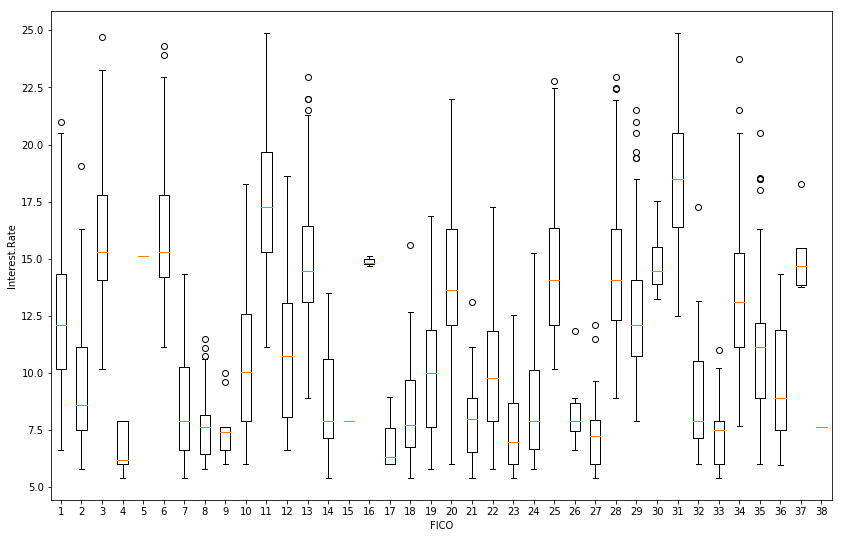

In [38]:
%%python

import json
import matplotlib.pyplot as plt

with open("/tmp/boxplot.data", "r") as f:
    arr = json.loads(f.read())
    
fig = plt.figure(figsize=(14, 9))
plt.boxplot(arr)
plt.xlabel("FICO")
plt.ylabel("Interest.Rate")